## Importando bibliotecas 

In [1]:
#Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import math
import config
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import KFold

#Importando as bibliotecas referentes ao XGBoost
import xgboost as xgb

#Importando as bibliotecas referentes ao ANN
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential

#Biblioteca do Kmeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

## A fazer
Kmeans do dados sem targets e agrupa pelo numero de grupos ótimos 

Mesma coisa com o dataset só dos targets 

Regressor Chain comum pelos targets

Regressor chain pelos grupos dos Kmeans 

Ensenmble de regressor chain



## Duvidas

## Funções

### Modelos

In [2]:
#DecisionTree
def model_dtree(x_train,y_train,x_test,booster,eta,max_depth,colsample_bytree,subsample,min_child_weight,reg_lambda,num_boost,my_num):
    bst = DecisionTreeRegressor().fit(x_train, y_train)
    predict = bst.predict(x_test)
    return predict

#RandomForestRegressor
def model_randomForest(x_train,y_train,x_test,my_num):
    #booster,eta,max_depth,colsample_bytree,subsample,min_child_weight,reg_lambda,num_boost):
    bst = RandomForestRegressor(n_estimators = my_num,n_jobs = -1).fit(x_train,y_train)
    predict = bst.predict(x_test)
    return predict

#SVR
def model_svr(x_train,y_train,x_test,ker,gam,c,epsi,shrink,verb,max_it):
    bst = SVR(kernel=ker, gamma=gam, C=c, epsilon=epsi, shrinking=shrink, verbose=verb, max_iter=max_it).fit(x_train,y_train)
    predict = bst.predict(x_test)
    return predict

def model_multi_dtree(x_train, y_train, x_test):
    model = DecisionTreeRegressor()
    bst = MultiOutputRegressor(model).fit(x_train, y_train)
    predict = bst.predict(x_test)
    return predict

def model_ann_global(x_train, y_train, x_test):
    model = Sequential()
    model.add(Input(shape = (x_train.shape[1])))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
    
    predict = model.predict(x_test)
    return predict

def model_ann_local(x_train, y_train, x_test):
    predict_list = []
    for i in range(y_train.shape[1]):
        model = Sequential()
        model.add(Input(shape = x_train.shape[1]))
        model.add(Dense(x_train.shape[1]//2, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(x_train.shape[1]//6, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(x_train.shape[1]//18, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        model.fit(x_train, y_train[:,i], epochs=10, batch_size=32, verbose=0, validation_split=0.2)

        predict = model.predict(x_test)
        predict_list.append(predict)
    
    predictions = np.concatenate(predict_list, axis=1)

    return predictions


def model_xgboost(x_train, y_train, x_test):
    param = {'max_depth': 4,
             'eta': 0.05, 
             'objective': 'reg:squarederror',
             'booster': 'gbtree',
            }
    bst = xgb.XGBRegressor(**param, n_estimators=100)
    bst.fit(x_train, y_train) 
    predict = bst.predict(x_test)
    return predict


### Cálculo de erro 

In [3]:
def computer_RRMSE_list(real_test,result_p,real_train_mean):
    """RRMSE: Relative Root Mean Square Error
        input: real_test: real test data
              result_p: predicted data
              real_train_mean: mean of real train data
        output: RRMSE list """

    _list = []
    for i in range(result_p.shape[1]):
        fenzi = 0
        fenmu = 0
        for j in range(result_p.shape[0]):
            fenzi += (result_p[j,i] - real_test[j,i])**2
            fenmu += (real_train_mean[i] - real_test[j,i])**2
        _list.append(math.sqrt(fenzi/fenmu))    
    return _list

## Implementação

In [4]:
path = "../TCC/mtr-datasets/"

#text_file = input("dataset: ")
text_file = 'andro'
data, meta = loadarff(path + text_file + ".arff")
data = pd.DataFrame(data)

data.reset_index(inplace=True)
data.replace('?', np.nan, inplace=True)
data.replace('     ?', np.nan, inplace=True)
data = data.applymap(float)

#Normalização
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


if config.all_config[text_file].get('sample_random') == True:
    data = data.sample(frac=1,random_state = config.all_config[text_file].get('sample_random_num')).reset_index(drop=True)
data = data.fillna(pd.Series(np.nanmean(data,axis=0),index=data.columns))
label = data.iloc[:,-config.all_config[text_file].get('targets_num'):].values
data = data.iloc[:,:-config.all_config[text_file].get('targets_num')].values

error_results = []

### Separação dos dados em Treino e Teste 


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

### Kmeans dos dados

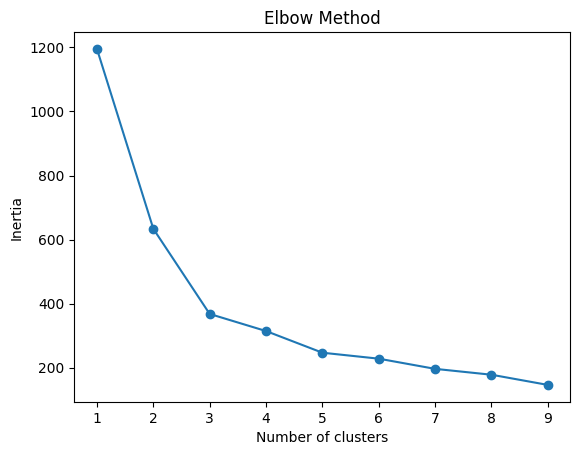

In [6]:
inertia_values = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto').fit(x_train)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [7]:
NUM_CLUSTER = config.all_config[text_file].get('num_cluster')
k_optimal = NUM_CLUSTER
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=0, n_init='auto').fit(x_train)

cluster_labels = kmeans_optimal.labels_

### Kmeans só dos targets

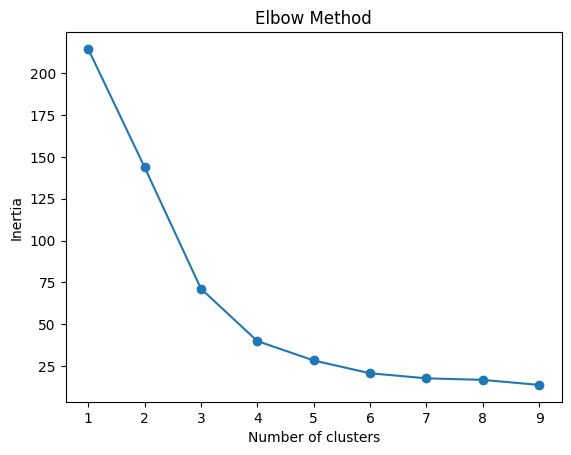

In [8]:
inertia_values = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto').fit(y_train)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [9]:
k_optimal = config.all_config[text_file].get("num_cluster_targets")
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=0, n_init='auto').fit(y_train)

cluster_labels_target = kmeans_optimal.labels_

### Regressor Chain Padrão

In [10]:
RANDOM_STATE = 0 
real_test_mean = y_test.mean(axis=0)
real_train_mean = y_train.mean(axis=0)

#### Caso de treino


In [12]:
loss_list_RRMSE = []

reg_chain = RegressorChain(RandomForestRegressor(random_state=RANDOM_STATE))
reg_chain.fit(x_train, y_train)
y_pred = reg_chain.predict(x_train)

loss_list_RRMSE = computer_RRMSE_list(y_train,y_pred,real_train_mean)
loss_list_RRMSE_np = np.array(loss_list_RRMSE)
mean_error = loss_list_RRMSE_np.mean(axis=0)
print(mean_error)

0.21766086518349556


#### Caso de teste

In [14]:
y_pred = reg_chain.predict(x_test)

loss_list_RRMSE = computer_RRMSE_list(y_test,y_pred,real_test_mean)
loss_list_RRMSE_np = np.array(loss_list_RRMSE)
mean_error = np.mean(loss_list_RRMSE_np,axis=0)
print(mean_error)
error_results.append(('Regressor Chain Padrão', loss_list_RRMSE_np.mean(axis=0)))

0.5377979510870844


### Regressor Chain pelos grupos dos Kmeans

conferir se deve separar a funcao para só dar o fit e depois predizer o caso de treino. pq ai consegue usar melhor no dicionario de predicoes 

In [15]:
# Define the train_regressor function
def train_regressor(cluster_train_data, label):
    indices = cluster_train_data.index
    y_train_cluster = label[indices]

    reg_chain = RegressorChain(RandomForestRegressor(random_state=RANDOM_STATE))
    reg_chain.fit(cluster_train_data, y_train_cluster)  

    y_pred = reg_chain.predict(cluster_train_data)

    real_train_mean_cluster = y_train_cluster.mean(axis=0)

    loss_list_RRMSE = computer_RRMSE_list(y_train_cluster, y_pred, real_train_mean_cluster)
    loss_list_RRMSE_np = np.array(loss_list_RRMSE)
    
    # Calculate the mean of the loss_list_RRMSE
    mean_loss_RRMSE = loss_list_RRMSE_np.mean(axis=0)
    print(mean_loss_RRMSE)

    return reg_chain

# Create a DataFrame with x_train data
data_cluster = pd.DataFrame(x_train)
data_cluster['cluster'] = cluster_labels

# Split the data into clusters
train_cluster = {cluster_label: data_cluster[data_cluster['cluster'] == cluster_label].drop(['cluster'], axis=1) for cluster_label in range(NUM_CLUSTER)}

# Train regressors for each cluster
trained_regressors = {cluster_label: train_regressor(cluster_train_data, label) for cluster_label, cluster_train_data in train_cluster.items()}

0.49434303860919293
0.4249124983042649
0.5084712448844999


In [16]:
def calculate_RRMSE(targets, valor, targets_mean):
    loss_list_RRMSE = computer_RRMSE_list(targets, valor, targets_mean)
    loss_list_RRMSE_np = np.array(loss_list_RRMSE)
    print('Valor:', loss_list_RRMSE_np.mean(axis=0))

In [17]:
y_pred_dict = {cluster_label: regressor.predict(x_test) for cluster_label, regressor in trained_regressors.items()}

for chave, value in y_pred_dict.items():
    calculate_RRMSE(y_test, y_pred_dict[chave], real_test_mean)

Valor: 0.9777541968796526
Valor: 1.2800620738054465
Valor: 1.14530679659355


Caso de treino 

In [18]:
y_pred_dict_train = {cluster_label: regressor.predict(x_train) for cluster_label, regressor in trained_regressors.items()}

#convertendo o dicionário para um array 
array_y_pred_train = np.array(list(y_pred_dict_train.values()))

valor_maximo = np.max(array_y_pred_train, axis=0)
valor_medio = np.mean(array_y_pred_train, axis=0)
valor_minimo = np.min(array_y_pred_train, axis=0)   

In [19]:
# Call the function with different values
print("Maxímo ", end="")
calculate_RRMSE(y_train, valor_maximo, real_train_mean)
print("Média ", end="")
calculate_RRMSE(y_train, valor_medio, real_train_mean)
print("Mínimo ", end="")
calculate_RRMSE(y_train, valor_minimo, real_train_mean)


Maxímo Valor: 1.1629924192798111
Média Valor: 0.9391589532305816
Mínimo Valor: 0.9897436065436951


Caso de Teste 

In [20]:
# aqui esta com x_test. precisa ver se é x_test ou x_train
y_pred_dict = {cluster_label: regressor.predict(x_test) for cluster_label, regressor in trained_regressors.items()}

#convertendo o dicionário para um array 
array_y_pred = np.array(list(y_pred_dict.values()))

valor_maximo = np.max(array_y_pred, axis=0)
valor_medio = np.mean(array_y_pred, axis=0)
valor_minimo = np.min(array_y_pred, axis=0)

In [21]:
# Call the function with different values
print("Maxímo: ", end="")
calculate_RRMSE(y_test, valor_maximo, real_test_mean)
print("Média: ", end="")
calculate_RRMSE(y_test, valor_medio, real_test_mean)
print("Mínimo: ", end="")
calculate_RRMSE(y_test, valor_minimo, real_test_mean)

Maxímo: Valor: 1.139380422095753
Média: Valor: 1.0674882930148861
Mínimo: Valor: 1.2248825329740778


Como cada cluster só ve o seu conjunto, depois na hora de pegar o maximo minimo e media, vem valores ruins pq os outros regressores nao foram treinados em conjuntos de dados semelhantes a esse 

### Ensemble Regressor Chain 

In [22]:
num_chain = label.shape[1]

ensemble = [RegressorChain(RandomForestRegressor(random_state=i)) for i in range(num_chain)]
for i, reg_chain in enumerate(ensemble):
    reg_chain.fit(x_train, y_train[:, [i]])

y_preds = np.column_stack([reg_chain.predict(x_test) for reg_chain in ensemble])

loss_list_RRMSE = computer_RRMSE_list(y_test, y_preds, real_train_mean)
loss_list_RRMSE_np = np.array(loss_list_RRMSE)
print(loss_list_RRMSE_np.mean(axis=0))
error_results.append(('Ensemble de Regressor Chain', loss_list_RRMSE_np.mean(axis=0)))

0.5611256934149038


In [23]:
# print the name and value of each model's error result
for model, error in error_results:
    print(f'{model} RRMSE: {error}')

Regressor Chain Padrão RRMSE: 0.5377979510870844
Ensemble de Regressor Chain RRMSE: 0.5611256934149038


## Modelos

#### MultiOutput Dtree

In [21]:
# Teste Multi-dtree
real_train_mean = y_train.mean(axis=0)

kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'), shuffle=config.all_config[text_file].get('kfold_random'))
for train_index , test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    result_p_train = model_multi_dtree(x_train, y_train, x_test)
    loss_list_RRMSE = computer_RRMSE_list(y_test,result_p_train,real_train_mean)
    loss_list_RRMSE_np = np.array(loss_list_RRMSE)
    mean_error = loss_list_RRMSE_np.mean(axis=0)

error_results.append(('MultiOutput Decision Tree: ', mean_error))
print("RRMSE: ", mean_error)

RRMSE:  0.5548410827525724


#### Random Forest Global 

In [26]:
loss_list_RRMSE = []

kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'),
            shuffle=config.all_config[text_file].get('kfold_random'),
            random_state=config.all_config[text_file].get('kfold_random_num'))

for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    result_p_train = model_randomForest(x_train, y_train, x_test, my_num=100) #call model_randomForest once
    
    real_train_mean = y_train.mean(axis=0)    
    loss_list_RRMSE.append(computer_RRMSE_list(y_test, result_p_train, real_train_mean))

loss_list_RRMSE_np = np.array(loss_list_RRMSE)
error_results.append(('Random Forest Global', loss_list_RRMSE_np.mean(axis=0)))
# print('RRMSE: ', loss_list_RRMSE_np)
# print('RRMSE mean: ', loss_list_RRMSE_np.mean(axis=0))

#### Random Forest Local 

In [7]:
loss_list_RRMSE = []

kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'),
            shuffle=config.all_config[text_file].get('kfold_random'),
            random_state=config.all_config[text_file].get('kfold_random_num'))

for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    result_p_train = []
    
    for i in range(label.shape[1]):

        predicted_test = None 

        if text_file in ['sf1', 'sf2']:
            predicted_test = model_svr(x_train, y_train[:,i], x_test,
                                    config.all_config[text_file].get('svr1_kernel'),
                                    config.all_config[text_file].get('svr1_gamma'),
                                    config.all_config[text_file].get('svr1_C'),
                                    config.all_config[text_file].get('svr1_epsilon'),
                                    config.all_config[text_file].get('svr1_shrinking'),
                                    config.all_config[text_file].get('svr1_verbose'),
                                    config.all_config[text_file].get('svr1_max_iter'))
        else:
            predicted_test = model_randomForest(x_train, y_train[:,i], x_test, my_num=100)
            
        result_p_train.append(predicted_test)

    result_p_train = pd.DataFrame(result_p_train).T.values
    real_train_mean = y_train.mean(axis=0)    
    loss_list_RRMSE.append(computer_RRMSE_list(y_test,result_p_train,real_train_mean))


loss_list_RRMSE_np = np.array(loss_list_RRMSE)
error_results.append(('Random Forest Local', loss_list_RRMSE_np.mean(axis=0)))
# print('RRMSE: ', loss_list_RRMSE_np)
# print('RRMSE mean: ',loss_list_RRMSE_np.mean(axis=0))


#### ANN Global 

In [8]:
loss_list_RRMSE = []

kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'),
            shuffle=config.all_config[text_file].get('kfold_random'),
            random_state=config.all_config[text_file].get('kfold_random_num'))

for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    result_p_train = model_ann_global(x_train, y_train, x_test)  # Call model_ann_global once
    
    real_train_mean = y_train.mean(axis=0)    
    loss_list_RRMSE.append(computer_RRMSE_list(y_test, result_p_train, real_train_mean))

loss_list_RRMSE_np = np.array(loss_list_RRMSE)
error_results.append(('ANN Global', loss_list_RRMSE_np.mean(axis=0)))
# print('RRMSE: ', loss_list_RRMSE_np)
# print('RRMSE mean: ', loss_list_RRMSE_np.mean(axis=0))

2023-11-24 19:17:43.857152: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 39ms/step


#### ANN Local

In [9]:
loss_list_RRMSE = []

kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'),
            shuffle=config.all_config[text_file].get('kfold_random'),
            random_state=config.all_config[text_file].get('kfold_random_num'))

for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    result_p_train = model_ann_local(x_train, y_train, x_test)
   
    real_train_mean = y_train.mean(axis=0)    

    result_p_train = pd.DataFrame(result_p_train).values
    loss_list_RRMSE.append(computer_RRMSE_list(y_test, result_p_train, real_train_mean))

    
loss_list_RRMSE_np = np.array(loss_list_RRMSE)
error_results.append(('ANN Local', loss_list_RRMSE_np.mean(axis=0)))
# print('RRMSE: ', loss_list_RRMSE_np)
# print('RRMSE mean: ',loss_list_RRMSE_np.mean(axis=0))

1/1 [==============================] - 0s 43ms/step


#### XGBoost Local

In [10]:
loss_list_RRMSE = []

kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'),
            shuffle=config.all_config[text_file].get('kfold_random'),
            random_state=config.all_config[text_file].get('kfold_random_num'))

for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    result_p_train = model_xgboost(x_train, y_train, x_test)
    
    real_train_mean = y_train.mean(axis=0)    
    loss_list_RRMSE.append(computer_RRMSE_list(y_test, result_p_train, real_train_mean))

loss_list_RRMSE_np = np.array(loss_list_RRMSE)
error_results.append(('XGBoost Local', loss_list_RRMSE_np.mean(axis=0)))
# print('RRMSE: ', loss_list_RRMSE_np)
# print('RRMSE mean: ', loss_list_RRMSE_np.mean(axis=0))

In [11]:
# print the name and value of each model's error result
for model, error in error_results:
    print(f'{model} RRMSE: {error}')

MultiOutput Decision Tree RRMSE: [0.40023333002332506, 0.02044705362869795, 0.7193043548966468, 0.7086654929709483, 0.6964982862873742, 0.9877161312990153]
Random Forest Global RRMSE: [0.31629909 0.2966071  0.30712246 0.30812334 0.52160143 0.55041904]
Random Forest Local RRMSE: [0.39453565 0.27027068 0.33402029 0.34314087 0.6460256  0.59859992]
ANN Global RRMSE: [0.87905475 0.86252126 0.96865246 0.99411114 1.03802282 1.00851647]
ANN Local RRMSE: [1.05904199 0.98890408 0.98386921 1.01469382 0.97670647 0.94233438]
XGBoost Local RRMSE: [0.3899991  0.13958916 0.36069351 0.33912269 0.6791775  0.6680659 ]


#### Parte errada ainda 

In [12]:
# # Ta errado ainda, 
# # A funcao model_ann_local ta iterando sobre as colunas
# # e nesse código ta iterando de novo sobre as colunas

# loss_list_RRMSE = []

# kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'),
#             shuffle=config.all_config[text_file].get('kfold_random'),
#             random_state=config.all_config[text_file].get('kfold_random_num'))

# for train_index, test_index in kf.split(data):
#     x_train, x_test = data[train_index], data[test_index]
#     y_train, y_test = label[train_index], label[test_index]

#     result_p_test = []

#     for i in range(label.shape[1]):
        
#         predicted_test = None 

#         if text_file in ['sf1', 'sf2']:
#             predicted_test = model_svr(x_train, y_train[:,i], x_test, y_test[:,i],
#                                     config.all_config[text_file].get('svr1_kernel'),
#                                     config.all_config[text_file].get('svr1_gamma'),
#                                     config.all_config[text_file].get('svr1_C'),
#                                     config.all_config[text_file].get('svr1_epsilon'),
#                                     config.all_config[text_file].get('svr1_shrinking'),
#                                     config.all_config[text_file].get('svr1_verbose'),
#                                     config.all_config[text_file].get('svr1_max_iter'))
#         else:
#             predicted_test = model_ann_local(x_train, y_train, x_test)
        
#         result_p_test.append(predicted_test)

#     result_p_test = pd.DataFrame(result_p_test).T.values
#     real_train_mean = y_train.mean(axis=0)    
#     loss_list_RRMSE.append(computer_RRMSE_list(y_test,result_p_test,real_train_mean))


# loss_list_RRMSE_np = np.array(loss_list_RRMSE)         
# print('RRMSE: ',np.mean(loss_list_RRMSE_np))